In [36]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.optimize
from scipy.stats import sem
import warnings
import os
import seaborn as sns

In [37]:
A_OPT = True # Generates a_opt vs theta Fig.
A_EQ = True  # Generates a_eq vs alpha Fig.
MF = True
FARBOODI = True
HMF = True
R_INF = True # Generates r_inf vs alpha Fig.
I_MAX = True
EPI_CURVES = True

In [38]:
dt = 1

# Population

N_tot = int(10000)
i0 = 0.01
delta = np.exp(-dt/10) # discount factor (decay time of ~10 days)

# Biological Parameters

mu = dt / 10 # Recovery rate (infection lasts ~10 days)
R0 = 3.
beta_MF = R0*mu # Technically it's beta*<k>

# CODE PARAMETERS

zero_tol = 1e-9  # value of i considered to be 0
t_max = round(1000/dt) # max lenght of simulations

# Colors
c1 = "#198ed5ff" # blue
c2 = "#b10d0dff" # red

# Range

alpha_grid = np.hstack((0,np.geomspace(0.1, 1000, 32)))

In [39]:
def colorFader(c1, c2, opacity=1, mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    color1=np.array(mpl.colors.to_rgba(c1))
    color1[3] *= opacity
    color2=np.array(mpl.colors.to_rgba(c2))
    color2[3] *= opacity
    return mpl.colors.to_hex(mix*color1 + (1-mix)*color2, keep_alpha=True)

## Optimal social activity

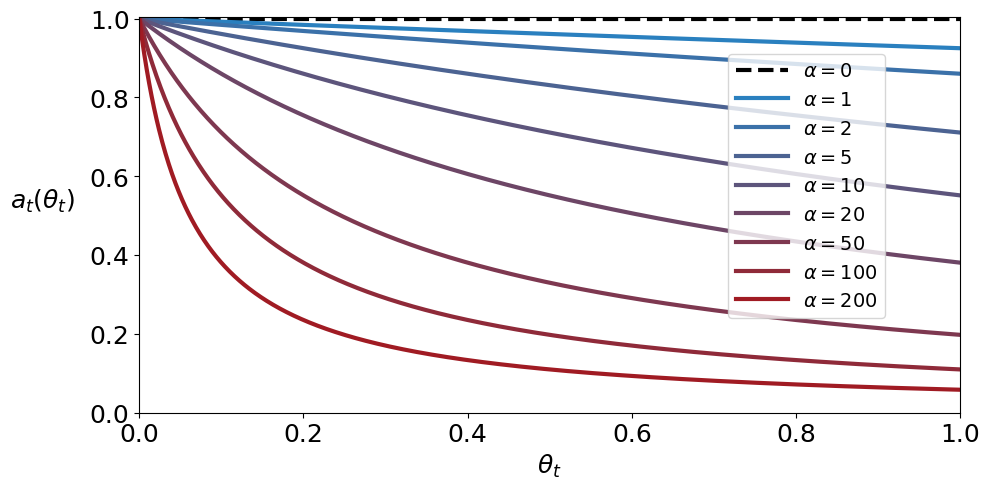

In [40]:
if A_OPT == True:
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5))

    fontsize = 18

    ax.set_xlabel("$\\theta_t$", fontsize=fontsize)
    ax.set_ylabel("$a_t(\\theta_t)$", fontsize=fontsize, labelpad=34).set_rotation(0)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)

    alpha_list = np.array([0, 1, 2, 5, 10, 20, 50, 100, 200])

    thetas = np.linspace(0, 1, 1000)

    for idx, alpha in enumerate(alpha_list):
        
        a_list = [1 / (1 + delta*(alpha/dt)*beta_MF*0.3*theta) for theta in thetas]  

        if alpha == 0:
            linestyle = "dashed"
            color = "black"
            label = "$\\alpha = 0$"
        else:  
            linestyle = "solid"
            color = colorFader(c2, c1, 1, idx/len(alpha_list))
            label = "$\\alpha = {}$".format(alpha)

        linewidth = 3

        ax.plot(thetas, a_list, label = label, linestyle=linestyle,
                color=color, linewidth=linewidth)
        
    #ax.text(0.5, .8, "$\delta={}$".format(delta),
    #        horizontalalignment='center',
    #        color = "k",
    #        fontsize=24)    
    
    plt.xlim(0,1)
    plt.ylim(0,1.005)
    fig.legend(prop={'size': 14}, handlelength=2.66, bbox_to_anchor=(0.9, 0.9))
    plt.tight_layout()
    plt.savefig("../Figures/a_opt/a_opt.pdf")
    plt.show()

### Equivalent social activity

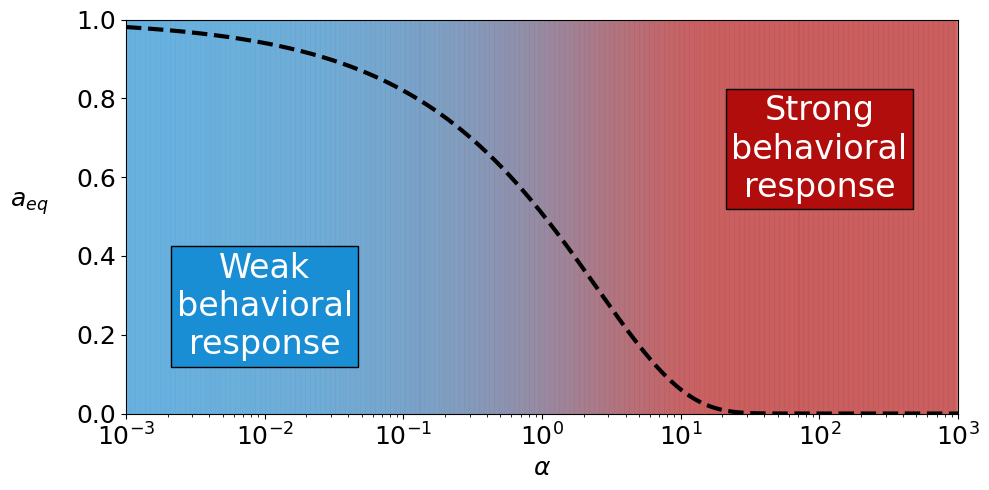

In [41]:
if A_EQ == True:

    def opt_fun(x, U_I):
        # Numerically find a_eq as the minimum of opt_fun
        return ( (np.log(x) - x + 1) + U_I)**2

    alpha_grid = np.geomspace(1e-3/dt, 1e3/dt, 1000)
    U_I_grid = (1-delta*(1-mu))*alpha_grid
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5))

    fontsize = 18

    ax.set_xlabel("$\\alpha$", fontsize=fontsize)
    ax.set_ylabel(r"$a_{eq}$", fontsize=fontsize, labelpad=34).set_rotation(0)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)

    # Calculate with U_I but plot corresponding alpha
    a_equiv = [scipy.optimize.fminbound(opt_fun, x1=0, x2=1, args=[U_I], disp=False, xtol=1e-15) for U_I in U_I_grid]
    ax.plot(alpha_grid, a_equiv, color="k", linestyle="dashed", linewidth=3, zorder=1)

    for i,x in enumerate(alpha_grid):
        ax.axvline(x, color=colorFader(c1, c2, 0.15, a_equiv[i]), linewidth=4, zorder=0)

    ax.text(1e-2/dt, .15, "Weak\nbehavioral\nresponse",
            horizontalalignment='center',
            color = "white",
            bbox=dict(facecolor=c1, alpha=1),
            fontsize=24)
    
    ax.text(1e2/dt, .55, "Strong\nbehavioral\nresponse",
            horizontalalignment='center',
            color = "white",
            bbox=dict(facecolor=c2, alpha=1),
            fontsize=24)  

    plt.xscale("log")
    plt.xlim(min(alpha_grid), max(alpha_grid))
    plt.ylim(0, 1)
    #ax.legend(prop={'size': 18}, handlelength=2.66)

    plt.tight_layout()
    plt.savefig("../Figures/a_eq/a_eq.pdf")
    plt.show()

## MF

In [42]:
def step_MF(Y, beta, mu, a):
    # s = 1 - Y[0] -Y[1]
    # i = Y[0]
    # r = Y[1]
     
    di = beta*(1 - Y[0] - Y[1])*a*a*Y[0]
    dr = Y[0]*mu
    
    i_new = Y[0] +di - dr
    r_new = Y[1] +dr
    
    return np.array([i_new, r_new])

In [43]:
def simulate_MF(t_max, beta, mu, alpha, i0):
    
    Y_list = []
    a_list = []
    
    eradicated = False

    tt = np.arange(0, t_max+dt, dt)
    
    Y = np.array([i0, 0]) #initial condition Y[0] = i, Y[1] = r
    a = 1
    
    for idx, t in enumerate(tt):
        
        s = 1 - Y[0] -Y[1]
    
        a = 1 / (1 + s*beta*(alpha/dt)*a*Y[0])
        
        if Y[0] < zero_tol:
            # If I = 0 the epidemic is over
            eradicated = True
            tt = tt[0:idx]
            break
        else:
            Y_list.append(Y)
            a_list.append(a)
        
        Y = step_MF(Y, beta, mu, a)
    
    Y_array = np.array(Y_list)
    a_time_series = np.array(a_list)
    
    time_series = {"s": 1 - Y_array[:,0] - Y_array[:,1],
                   "i": Y_array[:,0],
                   "r": Y_array[:,1]
                  }

    return tt, time_series, a_time_series, eradicated

In [44]:
def simulate_farboodi(t_max=round(1000/dt), beta= 0.3+ 1/7, mu=1/7, alpha=197, i0=5.27e-05, r0=2.51e-05):
    
    Y_list = []
    a_list = []
    
    eradicated = False

    tt = np.arange(0, t_max+dt, dt)
    
    Y = np.array([i0, 2.51e-05]) #initial condition Y[0] = i, Y[1] = r
    a = 1
    
    for idx, t in enumerate(tt):
        
        s = 1 - Y[0] -Y[1]
    
        a = 1 / (1 + s*beta*(alpha/dt)*a*Y[0])
        
        if Y[0] < zero_tol:
            # If I = 0 the epidemic is over
            eradicated = True
            tt = tt[0:idx]
            break
        else:
            Y_list.append(Y)
            a_list.append(a)
        
        Y = step_MF(Y, beta, mu, a)
    
    Y_array = np.array(Y_list)
    a_time_series = np.array(a_list)
    
    time_series = {"s": 1 - Y_array[:,0] - Y_array[:,1],
                   "i": Y_array[:,0],
                   "r": Y_array[:,1]
                  }

    return tt, time_series, a_time_series, eradicated

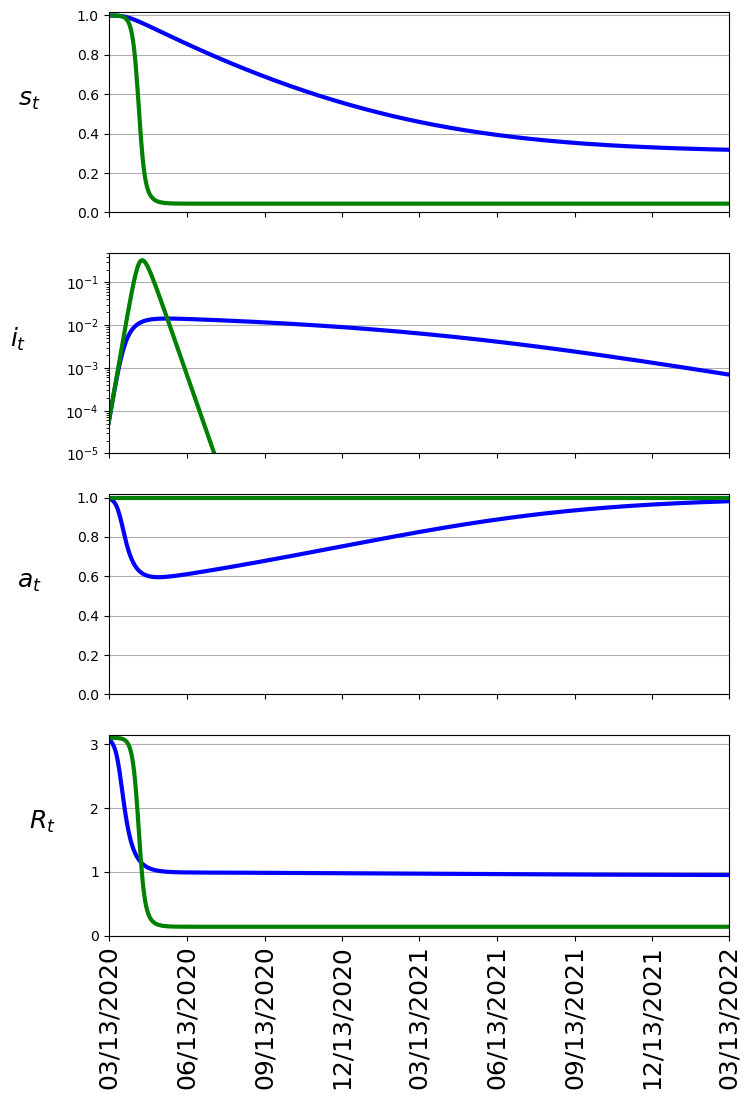

In [47]:
if FARBOODI == True:

    # comparison with the model of Farboodi et al. (2020) https://www.nber.org/papers/w27059

    fontsize = 18
    linewidth = 3

    fig, ax = plt.subplots(4,1, figsize=(8,12), sharex=True)

    # s
    # set ylim
    ax[0].set_ylim(0,1.02)
    ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax[0].set_ylabel("$s_t$", fontsize=fontsize, labelpad=34).set_rotation(0)
    # i
    ax[1].set_yscale("log")
    ax[1].set_yscale("log")
    ax[1].set_ylim(1e-5, 0.5)
    ax[1].set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5,])
    ax[1].set_ylabel("$i_t$", fontsize=fontsize, labelpad=34).set_rotation(0)
    # a
    ax[2].set_ylim(0,1.02)
    ax[2].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax[2].set_ylabel("$a_t$", fontsize=fontsize, labelpad=34).set_rotation(0)
    # R
    ax[3].set_ylim(0,3.15)
    ax[3].set_yticks([0, 1, 2, 3])
    ax[3].set_ylabel("$R_t$", fontsize=fontsize, labelpad=34).set_rotation(0)
    dates = [mpl.dates.datestr2num("03/13/2020"),
            mpl.dates.datestr2num("06/13/2020"),
            mpl.dates.datestr2num("09/13/2020"),
            mpl.dates.datestr2num("12/13/2020"),
            mpl.dates.datestr2num("03/13/2021"),
            mpl.dates.datestr2num("06/13/2021"),
            mpl.dates.datestr2num("09/13/2021"),
            mpl.dates.datestr2num("12/13/2021"),
            mpl.dates.datestr2num("03/13/2022")]
    ax[3].set_xticks(dates)
    ax[3].set_xticklabels(["03/13/2020", "06/13/2020", "09/13/2020", "12/13/2020", "03/13/2021", "06/13/2021", "09/13/2021", "12/13/2021", "03/13/2022"])
    ax[3].tick_params(axis='x', labelsize=fontsize, rotation=90)
    ax[3].set_xlim(dates[0], dates[-1])


    # Laissez-Faire
    
    delta = np.exp(-0.72/365)
    
    tt, equilibrium, a_eq, eradicated = simulate_farboodi(alpha=197)
    
    # make tt into dates starting from 03/13/2020
    # use format mm/dd/yyyy

    start_date = "03/13/2020"
    start_date = mpl.dates.datestr2num(start_date)
    tt = start_date + tt
    
    # s
    ax[0].plot(tt, equilibrium["s"], color="b", linewidth=linewidth, label="$i_t$")
    # i
    ax[1].plot(tt, equilibrium["i"], color="b", linewidth=linewidth, label="$i_t$")
    # a
    ax[2].plot(tt, a_eq, color="b", linewidth=linewidth, label="$a_t$")
    # R
    ax[3].plot(tt, (0.3 + 1/7) / (1/7)*a_eq*a_eq*equilibrium["s"], color="b", linewidth=linewidth, label="$a_t$")
    
    # SIR
    
    delta = np.exp(-0.72/365)
    
    _, sird, a_sird, eradicated = simulate_farboodi(alpha=0)
    
    # pad a with last value so it has the same length as tt
    a_sird = np.pad(a_sird, (0, len(tt)-len(a_sird)), 'edge')
    # pad result s,i and r with last value so it has the same length as tt
    sird["s"] = np.pad(sird["s"], (0, len(tt)-len(sird["s"])), 'edge')
    sird["i"] = np.pad(sird["i"], (0, len(tt)-len(sird["i"])), 'edge')
    sird["r"] = np.pad(sird["r"], (0, len(tt)-len(sird["r"])), 'edge')
    a_sird = np.pad(a_sird, (0, len(tt)-len(a_sird)), 'edge')

    # s
    ax[0].plot(tt, sird["s"], color="green", linewidth=linewidth, label="$i_t$")
    # i
    ax[1].plot(tt, sird["i"], color="green", linewidth=linewidth, label="$i_t$")
    # a
    ax[2].plot(tt, a_sird, color="green", linewidth=linewidth, label="$a_t$")
    # R
    ax[3].plot(tt, 3.1*a_sird*a_sird*sird["s"], color="green", linewidth=linewidth, label="$a_t$")
    #ax[3].set_ylim(0.8, 1.2)
    
        #fig.legend(prop={'size': 14}, handlelength=2.66, bbox_to_anchor=(0.87, 0.85))
    
    for axis in ax:
        axis.grid(axis='y')

In [51]:
if FARBOODI == True:
    u = (1-np.exp(-0.72/365)*(1-1/7))*197 # corresponding to alpha = 197
    a_eq = scipy.optimize.fminbound(opt_fun, x1=0, x2=1, args=[u], disp=False, xtol=1e-15)
    print(a_eq)

1.5801636824447066e-13


In [133]:
max(sird["i"]) - max(equilibrium["i"]) / max(sird["i"])

0.28694939253062784

In [134]:
max(sird["i"]) - 0.026 / max(sird["i"])

0.25153392753184145

In [132]:
0.026 / max(sird["i"])

0.07872589472771571

(18334.0, 18446.0)

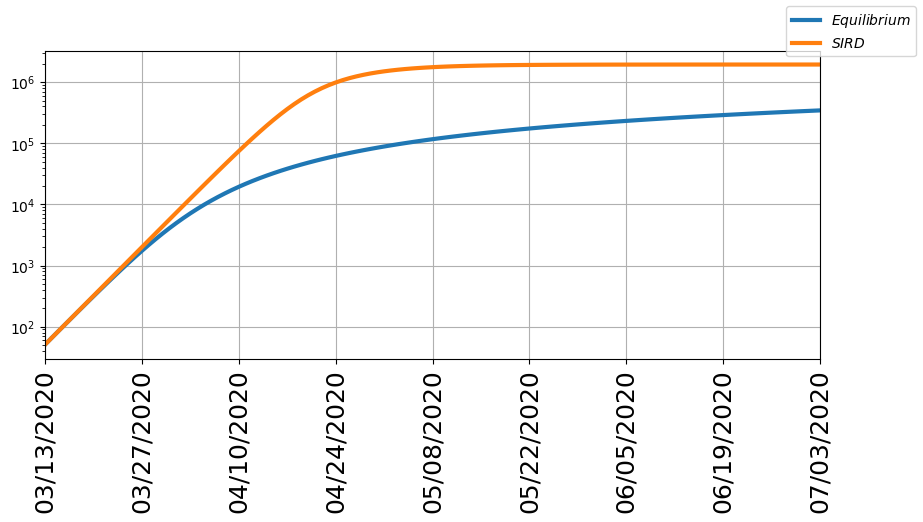

In [109]:
fig, ax = plt.subplots(1,1, figsize=(10,4))

pi = 0.0062 # fatalty rate

# plot fatalties in the US (Equilibrium and SIRD)
ax.plot(tt, 328e6*pi*equilibrium["r"], linewidth=linewidth, label="$Equilibrium$") # Equilibrium
ax.plot(tt, 328e6*pi*sird["r"], linewidth=linewidth, label="$SIRD$") # SIRD
ax.set_yscale("log")
ax.grid()
fig.legend()


dates_fat = [mpl.dates.datestr2num("03/13/2020"),
            mpl.dates.datestr2num("03/27/2020"),
            mpl.dates.datestr2num("04/10/2020"),
            mpl.dates.datestr2num("04/24/2020"),
            mpl.dates.datestr2num("05/08/2020"),
            mpl.dates.datestr2num("05/22/2020"),
            mpl.dates.datestr2num("06/05/2020"),
            mpl.dates.datestr2num("06/19/2020"),
            mpl.dates.datestr2num("07/03/2020")]
ax.set_xticks(dates_fat)
ax.set_xticklabels(["03/13/2020", "03/27/2020", "04/10/2020", "04/24/2020", "05/08/2020", "05/22/2020", "06/05/2020", "06/19/2020", "07/03/2020"])
ax.tick_params(axis='x', labelsize=fontsize, rotation=90)
ax.set_xlim(dates_fat[0], dates_fat[-1])

In [110]:
# fatalties on July 1st

day = mpl.dates.datestr2num("07/01/2020")

sird_july = 328e6*pi*sird["r"][np.where(tt == day)][0]
eq_july = 328e6*pi*equilibrium["r"][np.where(tt == day)][0]

# SIRD
print(f"SIRD: {sird_july}")
# Equilibrium
print(f"Equilibrium: {eq_july}")

SIRD: 1943244.8244630515
Equilibrium: 337423.3282909308


In [125]:
(sird_july - eq_july) / sird_july

0.826360876384083

In [122]:
337423 / 564000

0.5982677304964539

In [123]:
equilibrium["r"][-1] / sird["r"][-1]

0.7251248925768875

(18334.0, 18446.0)

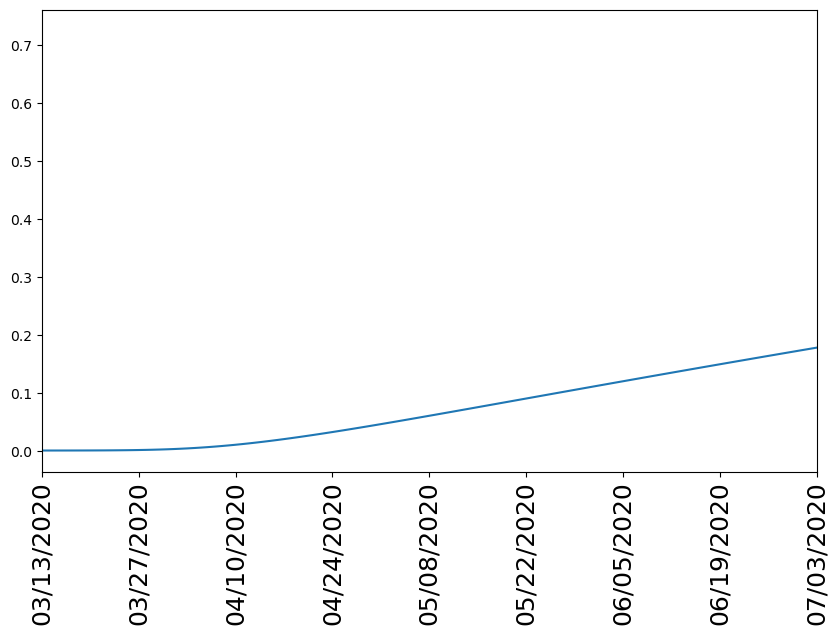

In [120]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(tt, equilibrium["r"]/sird["r"][-1])

ax.set_xticks(dates_fat)
ax.set_xticklabels(["03/13/2020", "03/27/2020", "04/10/2020", "04/24/2020", "05/08/2020", "05/22/2020", "06/05/2020", "06/19/2020", "07/03/2020"])
ax.tick_params(axis='x', labelsize=fontsize, rotation=90)
ax.set_xlim(dates_fat[0], dates_fat[-1])

In [86]:
eq_july / sird_july

0.17363912361591702

In [85]:
564000 / 1925000

0.29298701298701296

In [81]:
(sird_july - eq_july) / sird_july

0.826360876384083

In [74]:
328e6*pi*sird["r"][np.where(tt == day)][0]

1943244.8244630515

In [11]:
mpl.dates.num2date(tt[result["i"] == result["i"].max()])

[datetime.datetime(2020, 5, 23, 0, 0, tzinfo=datetime.timezone.utc)]

In [14]:
t_may = mpl.dates.datestr2num("05/01/2020"),
result["i"][tt == t_may]

array([0.01235325])

In [47]:
(np.append(ax[3].get_xticks(), start_date).sort())

3.1

In [41]:
mpl.dates.num2date(tt)

[datetime.datetime(2020, 3, 13, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 3, 14, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 3, 15, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 3, 16, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 3, 17, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 3, 18, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 3, 19, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 3, 20, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 3, 21, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 3, 22, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 3, 23, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 3, 24, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 3, 25, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 3, 26, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 3, 27, 0,

In [ ]:
start_date

18334.0

## HMF

In [10]:
# (Annealed) network generation

k_min = 5                  # min degree
k_max = int(N_tot**(0.5))  # max degree
gamma = 2.1                # power law exponent p_k = C*k^{-gamma}

degrees = np.arange(k_min, k_max+1, 1)

p = {}

for k in degrees: 
    p[k] = np.array(k**(-gamma))

norm = sum([p[k] for k in degrees])

for k in degrees: 
    p[k] /= norm #normalize p_k

k_ave = sum([k * p[k] for k in degrees])
k_var = sum([k**2*p[k] for k in degrees])

beta_HMF = mu*R0/k_ave
#print("The average degree is: {}".format(k_ave))
#print("The average transmission rate is: {}".format(beta_HMF*k_ave))

In [11]:
def step_HMF(Y, beta, mu, a, theta):
# Right-hand side of the differential eq. system
# indexes from 0 to len(degrees)-1 are for i_k,
# indexes from len(degrees) to 2*len(degrees)-1 to are for r_k
    
    di = np.array([beta*(1-Y[i]-Y[len(Y)//2+i])*degrees[i]*a[degrees[i]]*theta \
                   for i in range(0,len(Y)//2)])
    
    dr = np.array([mu*Y[i] for i in range(0,len(Y)//2)])
    
    dYdt = np.zeros(len(Y))
    dYdt[:len(Y)//2]  = +di - dr
    dYdt[len(Y)//2:]  = +dr
    
    return Y + dYdt

In [12]:
def simulate_HMF(t_max, beta, mu, alpha, i0):
    
    Y_list = []
    a_list = []
    theta_list = []
    
    eradicated = False

    tt = np.arange(0, t_max+dt, dt)
    
    init = np.zeros(2*len(degrees))   # indexes from 0 to len(degrees)-1 are for i_k,
                                      # indexes from len(degrees) to 2*len(degrees)-1 to are for r_k
    for k in degrees:
        init[k-k_min] = i0
        
    Y = np.array([elem for elem in init]) #initial conditions
    
    theta = sum([(k-1)*p[k]*Y[k-k_min]/k_ave for k in degrees]) # Density of infected neighbours
    # there is no a[k] in theta because at t=0 a[k] = 1
    
    a = {}
    for k in degrees:
        a[k] = 1
    
    a_time_series = {}
    for k in degrees:
        a_time_series[k] = []
    
    for idx, t in enumerate(tt):
        
        if all(Y[0:len(degrees)] < zero_tol):
            # If I = 0 the epidemic is over
            eradicated = True
            tt = tt[0:idx]
            break
        else:
            Y_list.append(Y)
            theta_list.append(theta)
            for k in degrees:
                a_time_series[k].append(a[k])
        
        for k in degrees:
            s_k  = 1 - Y[k-k_min] - Y[len(degrees)+k-k_min]
            a[k] = 1 / (1 + s_k*(alpha/dt)*delta*beta*k*theta)
        
        # Theta changes because of changes in a_k
        theta = sum([a[k]*(k-1)*p[k]*Y[k-k_min]/k_ave for k in degrees])
        
        Y = step_HMF(Y, beta, mu, a, theta) # Advance
        
        # Theta changes because of changes in i_k
        theta = sum([a[k]*(k-1)*p[k]*Y[k-k_min]/k_ave for k in degrees])

    for k in degrees:
        a_time_series[k] = np.array(a_time_series[k])
            
    Y_array = np.array(Y_list)
    theta_time_series = np.array(theta_list)
    
    i_k = Y_array[:,0:len(degrees)]
    r_k = Y_array[:,len(degrees):]
    
    i_dict = {} 
    r_dict = {} 

    for k_idx, k in enumerate(degrees):
        i_dict[k] = i_k[:,k_idx]
        r_dict[k] = r_k[:,k_idx]

    time_series = {"i": i_dict,
                   "r": r_dict
                  }
    
    return tt, time_series, a_time_series, theta_time_series, eradicated # heterogeneous

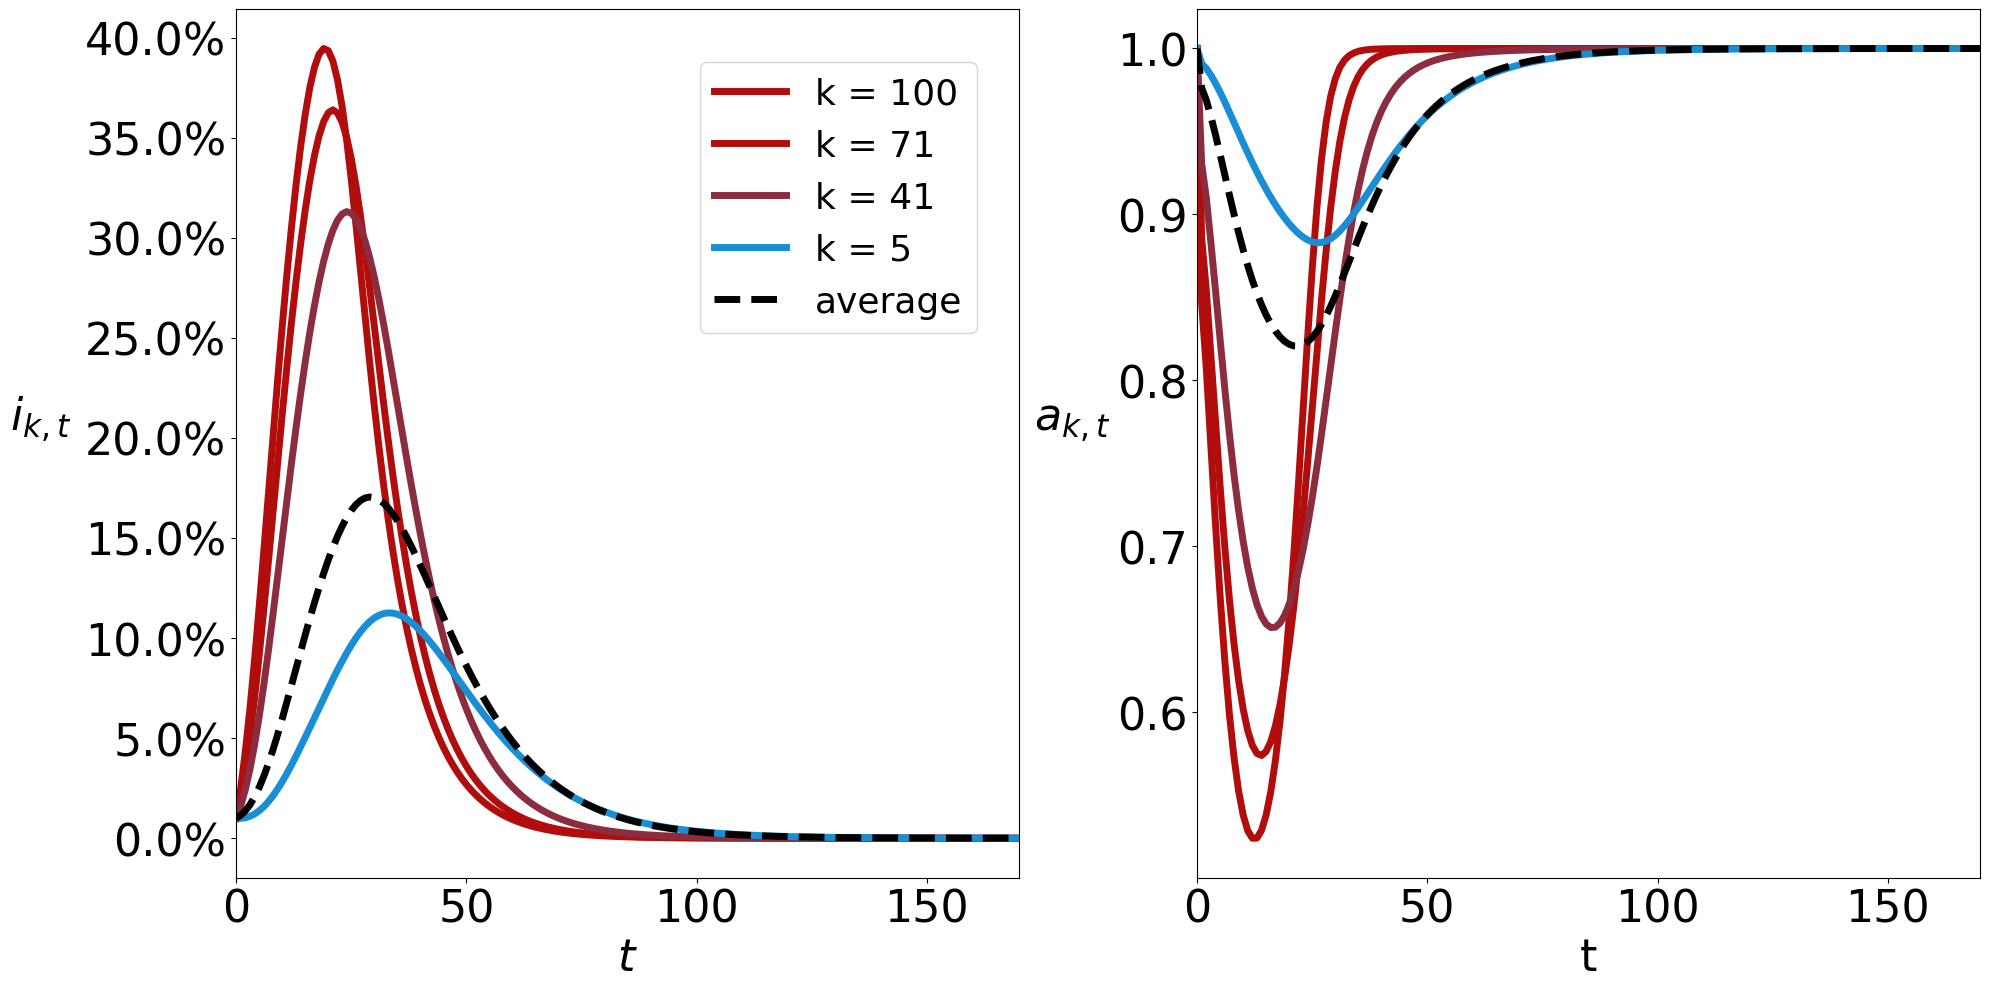

In [13]:
if HMF == True:

    linewidth = 5

    fig, ax = plt.subplots(1,2, figsize=(20,10))

    fontsize = 32
    padsize = 32
    ticksize = 32

    ax1 = ax[0]
    ax2 = ax[1]

    ax1.set_xlabel('$t$', fontsize = fontsize)
    ax1.set_ylabel(r'$i_{k,t}$', fontsize = fontsize, labelpad=fontsize).set_rotation(0)
    ax1.tick_params(axis='y', labelsize=ticksize)
    ax1.tick_params(axis='x', labelsize=ticksize)
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter()) #display "%" sign on y axis

    ax2.set_xlabel('t', fontsize = fontsize)
    ax2.set_ylabel(r'$a_{k,t}$', fontsize = fontsize, labelpad=fontsize).set_rotation(0)
    #ax2.set_ylim(0, 1)
    ax2.tick_params(axis='x', labelsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)

    tt, result, a, theta, eradicated = simulate_HMF(t_max, beta_HMF, mu, 10, i0)

    if not eradicated:
        print("WARNING: tmax was reached")

    percent = {}

    for k_idx, k in enumerate(degrees):
        percent[k] = np.array([elem*100 for elem in result["i"][k]])  # Percentage of I

    kstep = 30

    ax1.plot(tt, percent[k_max], label="k = {}".format(k_max), color=c2, linewidth = linewidth) #Always display k_max
    ax2.plot(tt, a[k_max], color=c2, linestyle = "solid", linewidth = linewidth)
    for k_idx, k in enumerate(degrees[-kstep:kstep:-kstep]): # Plot only a fraction of all degrees
        color = colorFader(c1, c2, 1, k_idx/len(degrees[::-kstep]))
        ax1.plot(tt, percent[k], label="k = {}".format(k), color=color, linewidth = linewidth)
        ax2.plot(tt, a[k], color=color, linestyle = "solid", linewidth = linewidth)
    ax1.plot(tt, percent[k_min], label="k = {}".format(k_min), color=c1, linewidth = linewidth) #Always display k_min
    ax2.plot(tt, a[k_min], color=c1, linestyle = "solid", linewidth = linewidth)


    percent_tot = np.vstack(([np.pad(percent[k]*p[k],[(0, len(tt)-len(percent[k]))], mode='constant') # constant mode 
                          for k in degrees])).sum(axis=0)                                         # defaults to 0
    a_ave = np.vstack(([np.pad(a[k]*p[k],[(0, len(tt)-len(a[k]))], mode='constant')
                          for k in degrees])).sum(axis=0)

    ax1.plot(tt, percent_tot, color="k", linestyle = "dashed", linewidth = linewidth, label="average")  
    ax2.plot(tt, a_ave, color="k", linestyle = "dashed", linewidth = linewidth)

    fig.legend(bbox_to_anchor=(0.5, 0.95), prop={'size': 26})
    fig.tight_layout()  # otherwise the right y-label is slightly clipped   
    ax1.set_xlim(0, 170)
    ax2.set_xlim(0, 170)
    plt.show()

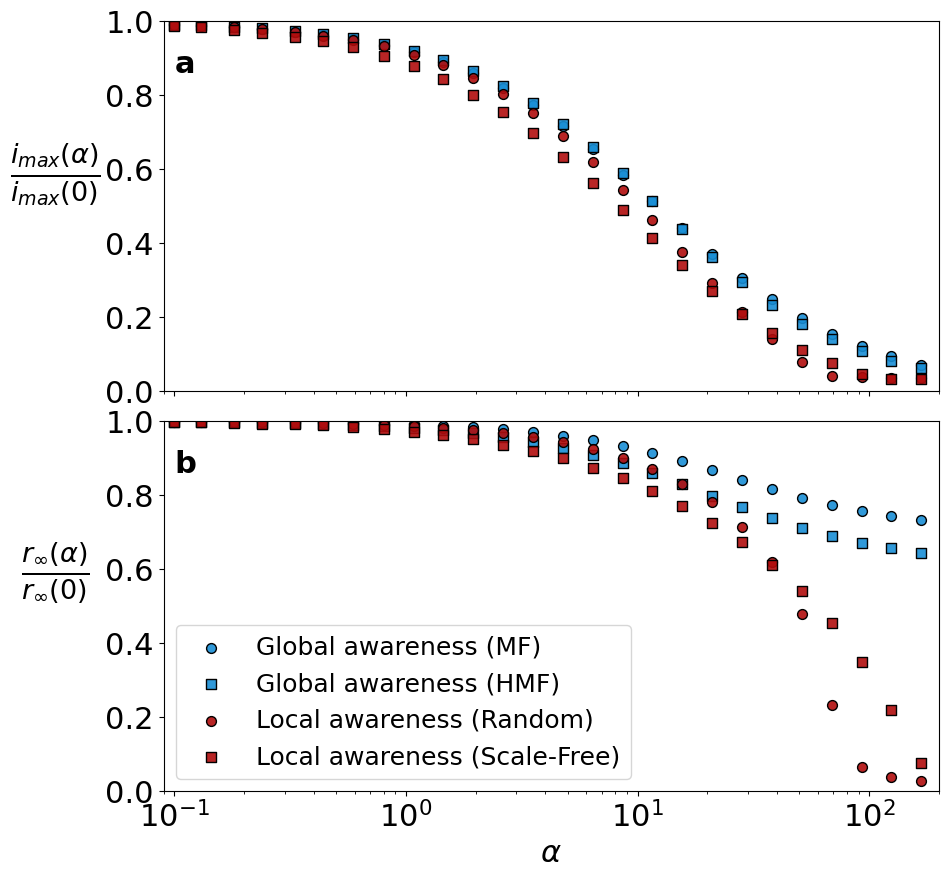

In [14]:
if R_INF == True and I_MAX == True:
    
    alpha_grid = []

    random_path = "../Data/RandomNetworkData/"
    scalefree_path = "../Data/ScaleFreeData/"

    for dirname in os.listdir(random_path):
        if os.path.isdir(random_path+dirname): # Check that it's actually a directory
            alpha_grid.append(float(dirname.replace("alpha=", "")))

    alpha_grid.sort()        
    alpha_grid = np.array(alpha_grid)

    fontsize = 22
    bigfontsize = 28
    linewidth = 1
    markersize = 50

    c1 = "#b10d0dff" # red
    c1_light = np.array(mpl.colors.to_rgba(c1))
    c1_light[3] *= 0.9
    c2 = "#198ed5ff" # blue
    c2_light = np.array(mpl.colors.to_rgba(c2))
    c2_light[3] *= 0.9

    plt.rcParams['legend.title_fontsize'] = 24

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex='col', sharey='row')
    fig.subplots_adjust(hspace=0.08)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=True)

    ax2.set_ylabel(r'$\frac {{ r_{\infty}(\alpha) }}{{r_{\infty}(0)}}$', fontsize = bigfontsize, labelpad = 36).set_rotation(0)
    ax2.tick_params(axis='both', which='both', labelsize = fontsize)
    ax2.set_xscale("log")
    ax2.set_xlabel('$\\alpha$', fontsize = fontsize)
    
    ax1.set_ylabel(r'$\frac {{ i_{max}(\alpha) }}{{i_{max}(0)}}$', fontsize = bigfontsize, labelpad = 36).set_rotation(0)
    ax1.tick_params(axis='both', which='both', labelsize = fontsize)
    ax1.set_xscale("log")

    #ax2.yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8])

    for idx, alpha in enumerate(alpha_grid):
        print("", end='\r')
        print(" Simulating alpha = {:.2f} ({}/{})".format(alpha, idx+1, len(alpha_grid)), end='\r')

        # MF

        tt, result_MF, a, eradicated = simulate_MF(t_max, beta_MF, mu, alpha, i0)

        if alpha == 0:
            MF_i_max_0 = max(result_MF["i"])
            r_inf_0_MF = result_MF["r"][-1]
            ax2.scatter([],[], linewidth=linewidth,
                    facecolor=c2_light, marker = "o",
                    label="Global awareness (MF)", s=markersize, edgecolor="k")
        else:
            ax2.scatter(alpha, result_MF["r"][-1]/r_inf_0_MF,
                       linewidth=linewidth, facecolor=c2_light,
                       marker = "o", s=markersize,
                       edgecolor="k")
            ax1.scatter(alpha, max(result_MF["i"])/MF_i_max_0,
                       linewidth=linewidth, facecolor=c2_light, marker = "o",
                       s=markersize, edgecolor="k")

        # HMF

        tt, result_HMF, a, theta, eradicated = simulate_HMF(t_max, beta_HMF, mu, alpha, i0)

        res_i_tot = np.vstack(([np.pad(result_HMF["i"][k]*p[k],[(0, len(tt)-len(result_HMF["i"][k]))], mode='constant') # constant mode 
                          for k in degrees])).sum(axis=0)    # defaults to 0
        res_r_tot = np.vstack(([np.pad(result_HMF["r"][k]*p[k],[(0, len(tt)-len(result_HMF["r"][k]))], mode='constant') # constant mode 
                  for k in degrees])).sum(axis=0)

        if alpha == 0:
            HMF_i_max_0 = max(res_i_tot)
            r_inf_0_HMF = res_r_tot[-1]
            ax2.scatter([],[], facecolor=c2_light,
                       linewidth=linewidth, marker = "s",
                       label="Global awareness (HMF)", s=markersize,
                       edgecolor="k")
        else:
            ax2.scatter(alpha, res_r_tot[-1]/r_inf_0_HMF,
                       linewidth=linewidth, facecolor=c2_light, marker = "s",
                       s=markersize, edgecolor="k")
            ax1.scatter(alpha, max(res_i_tot)/HMF_i_max_0,
                       linewidth=linewidth, facecolor=c2_light, marker = "s",
                       s=markersize, edgecolor="k")

        # Random Network

        random_sims_matrix = np.load(random_path+"/alpha="+str(alpha)+"/simulations.npy")
        r_inf = np.load(random_path+"/alpha="+str(alpha)+"/r_inf.npy")

        if alpha == 0:
            random_i_max_0 = np.mean([max(run) for run in random_sims_matrix])
            r_inf_0_random = np.mean(r_inf) # mean value of r_inf with alpha = 0
            ax2.scatter([],[], facecolor=c1_light, marker = "o",
                    linewidth=linewidth, label="Local awareness (Random)",
                    s=markersize, edgecolor="k")
        else:
            i_max = np.mean([max(run) for run in random_sims_matrix])
            r_inf_mean = np.mean(r_inf) # mean value of r_inf
            ax2.scatter(alpha, r_inf_mean/r_inf_0_random,
                    linewidth=linewidth, facecolor=c1_light, marker = "o",
                    s=markersize, edgecolor="k")
            ax1.scatter(alpha, i_max/random_i_max_0,
                       linewidth=linewidth, facecolor=c1_light, marker = "o",
                       s=markersize, edgecolor="k")

        # Scale-Free Network

        scalefree_sims_matrix = np.load(scalefree_path+"/alpha="+str(alpha)+"/simulations.npy")
        r_inf = np.load(scalefree_path+"/alpha="+str(alpha)+"/r_inf.npy")

        if alpha == 0:
            scalefree_i_max_0 = np.mean([max(run) for run in scalefree_sims_matrix])
            r_inf_0_scalefree = np.mean(r_inf)
            ax2.scatter([],[], facecolor=c1_light, marker = "s",
                    linewidth=linewidth, label="Local awareness (Scale-Free)",
                    s=markersize, edgecolor="k")
        else:
            i_max = np.mean([max(run) for run in scalefree_sims_matrix])
            r_inf_mean = np.mean(r_inf) # mean value of r_inf
            ax2.scatter(alpha, np.mean(r_inf)/r_inf_0_scalefree,
                    linewidth=linewidth, facecolor=c1_light,
                    marker = "s", s=markersize, edgecolor="k")
            ax1.scatter(alpha, i_max/scalefree_i_max_0,
                       linewidth=linewidth, facecolor=c1_light, marker = "s",
                       s=markersize, edgecolor="k")

    alpha_min = min(alpha_grid)
    alpha_max = max(alpha_grid)
    
    ax1.text(1e-1, 0.86, r"$\bf{a}$", horizontalalignment='left', fontsize=22)
    ax2.text(1e-1, 0.86, r"$\bf{b}$", horizontalalignment='left', fontsize=22)

    #ax1.set_xlim(0.09, 1.1*alpha_max)
    #ax2.set_xlim(0.09, 1.1*alpha_max)
    
    ax1.set_xlim(0.09, 200)
    ax2.set_xlim(0.09, 200)

    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)

    ax2.legend(prop={'size': 18}, fontsize='big')

    #fig.tight_layout()
    plt.savefig("../Figures/subplot/subplot.pdf", bbox_inches='tight')
    plt.show()

In [15]:
# if R_INF == True and I_MAX == True:
    # Not scaled

    alpha_grid = []

    random_path = "../Data/RandomNetworkData/"
    scalefree_path = "../Data/ScaleFreeData/"

    for dirname in os.listdir(random_path):
        if os.path.isdir(random_path+dirname): # Check that it's actually a directory
            alpha_grid.append(float(dirname.replace("alpha=", "")))

    alpha_grid.sort()        
    alpha_grid = np.array(alpha_grid)

    fontsize = 22
    bigfontsize = 28
    linewidth = 1
    markersize = 50

    c1 = "#b10d0dff" # red
    c1_light = np.array(mpl.colors.to_rgba(c1))
    c1_light[3] *= 0.9
    c2 = "#198ed5ff" # blue
    c2_light = np.array(mpl.colors.to_rgba(c2))
    c2_light[3] *= 0.9

    plt.rcParams['legend.title_fontsize'] = 24

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex='col', sharey='row')
    fig.subplots_adjust(hspace=0.08)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=True)

    ax2.set_ylabel(r'$r_{\infty}(\alpha)$', fontsize = fontsize, labelpad = 36).set_rotation(0)
    ax2.tick_params(axis='both', which='both', labelsize = fontsize)
    ax2.set_xscale("log")
    ax2.set_xlabel('$\\alpha$', fontsize = fontsize)
    
    ax1.set_ylabel(r'$i_{max}(\alpha)$', fontsize = fontsize, labelpad = 36).set_rotation(0)
    ax1.tick_params(axis='both', which='both', labelsize = fontsize)
    ax1.set_xscale("log")

    #ax2.yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8])

    for idx, alpha in enumerate(alpha_grid):
        print("", end='\r')
        print(" Simulating alpha = {:.2f} ({}/{})".format(alpha, idx+1, len(alpha_grid)), end='\r')

        # MF

        tt, result_MF, a, eradicated = simulate_MF(t_max, beta_MF, mu, alpha, i0)

        if alpha == 0:
            MF_i_max_0 = max(result_MF["i"])
            r_inf_0_MF = result_MF["r"][-1]
            ax2.scatter([],[], linewidth=linewidth,
                    facecolor=c2_light, marker = "o",
                    label="Global awareness (MF)", s=markersize, edgecolor="k")
        else:
            ax2.scatter(alpha, result_MF["r"][-1],
                       linewidth=linewidth, facecolor=c2_light,
                       marker = "o", s=markersize,
                       edgecolor="k")
            ax1.scatter(alpha, max(result_MF["i"]),
                       linewidth=linewidth, facecolor=c2_light, marker = "o",
                       s=markersize, edgecolor="k")

        # HMF

        tt, result_HMF, a, theta, eradicated = simulate_HMF(t_max, beta_HMF, mu, alpha, i0)

        res_i_tot = np.vstack(([np.pad(result_HMF["i"][k]*p[k],[(0, len(tt)-len(result_HMF["i"][k]))], mode='constant') # constant mode 
                          for k in degrees])).sum(axis=0)    # defaults to 0
        res_r_tot = np.vstack(([np.pad(result_HMF["r"][k]*p[k],[(0, len(tt)-len(result_HMF["r"][k]))], mode='constant') # constant mode 
                  for k in degrees])).sum(axis=0)

        if alpha == 0:
            HMF_i_max_0 = max(res_i_tot)
            r_inf_0_HMF = res_r_tot[-1]
            ax2.scatter([],[], facecolor=c2_light,
                       linewidth=linewidth, marker = "s",
                       label="Global awareness (HMF)", s=markersize,
                       edgecolor="k")
        else:
            ax2.scatter(alpha, res_r_tot[-1],
                       linewidth=linewidth, facecolor=c2_light, marker = "s",
                       s=markersize, edgecolor="k")
            ax1.scatter(alpha, max(res_i_tot),
                       linewidth=linewidth, facecolor=c2_light, marker = "s",
                       s=markersize, edgecolor="k")

        # Random Network

        random_sims_matrix = np.load(random_path+"/alpha="+str(alpha)+"/simulations.npy")
        r_inf = np.load(random_path+"/alpha="+str(alpha)+"/r_inf.npy")

        if alpha == 0:
            random_i_max_0 = np.mean([max(run) for run in random_sims_matrix])
            r_inf_0_random = np.mean(r_inf) # mean value of r_inf with alpha = 0
            ax2.scatter([],[], facecolor=c1_light, marker = "o",
                    linewidth=linewidth, label="Local awareness (Random)",
                    s=markersize, edgecolor="k")
        else:
            i_max = np.mean([max(run) for run in random_sims_matrix])
            r_inf_mean = np.mean(r_inf) # mean value of r_inf
            ax2.scatter(alpha, r_inf_mean,
                    linewidth=linewidth, facecolor=c1_light, marker = "o",
                    s=markersize, edgecolor="k")
            ax1.scatter(alpha, i_max,
                       linewidth=linewidth, facecolor=c1_light, marker = "o",
                       s=markersize, edgecolor="k")

        # Scale-Free Network

        scalefree_sims_matrix = np.load(scalefree_path+"/alpha="+str(alpha)+"/simulations.npy")
        r_inf = np.load(scalefree_path+"/alpha="+str(alpha)+"/r_inf.npy")

        if alpha == 0:
            scalefree_i_max_0 = np.mean([max(run) for run in scalefree_sims_matrix])
            r_inf_0_scalefree = np.mean(r_inf)
            ax2.scatter([],[], facecolor=c1_light, marker = "s",
                    linewidth=linewidth, label="Local awareness (Scale-Free)",
                    s=markersize, edgecolor="k")
        else:
            i_max = np.mean([max(run) for run in scalefree_sims_matrix])
            r_inf_mean = np.mean(r_inf) # mean value of r_inf
            ax2.scatter(alpha, np.mean(r_inf),
                    linewidth=linewidth, facecolor=c1_light,
                    marker = "s", s=markersize, edgecolor="k")
            ax1.scatter(alpha, i_max,
                       linewidth=linewidth, facecolor=c1_light, marker = "s",
                       s=markersize, edgecolor="k")

    alpha_min = min(alpha_grid)
    alpha_max = max(alpha_grid)
    
    ax1.text(0.85*alpha_max, 0.28, r"$\bf{a}$", horizontalalignment='left', fontsize=22)
    ax2.text(0.85*alpha_max, 0.85, r"$\bf{b}$", horizontalalignment='left', fontsize=22)

    ax1.set_xlim(0.09, 1.1*alpha_max)
    #ax1.set_ylim(0, 1)

    ax2.set_xlim(0.09, 1.1*alpha_max)
    #ax2.set_ylim(0, 1)

    ax2.legend(prop={'size': 18}, fontsize='big')

    #fig.tight_layout()
    #plt.savefig("../Figures/subplot/subplot.pdf", bbox_inches='tight')
    #plt.show()

IndentationError: unexpected indent (1620238130.py, line 4)

In [16]:
import matplotlib.patheffects as pe

21.0


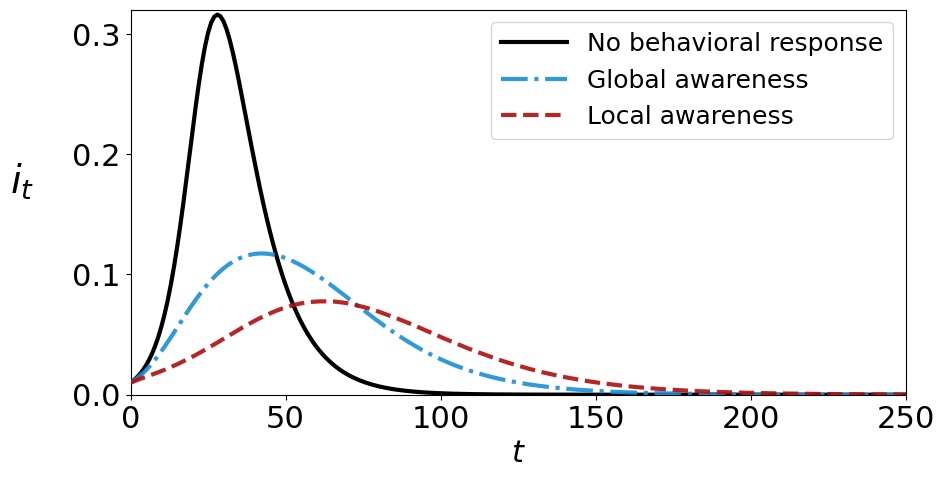

In [94]:
if EPI_CURVES == True:
    
    t_lim = 250
    alpha_grid = []

    random_path = "../Data/RandomNetworkData/"
    scalefree_path = "../Data/ScaleFreeData/"

    for dirname in os.listdir(random_path):
        if os.path.isdir(random_path+dirname): # Check that it's actually a directory
            alpha_grid.append(float(dirname.replace("alpha=", "")))

    alpha_grid.sort()        
    alpha_grid = np.array(alpha_grid)

    linewidth = 3
    transparency = 1

    c1 = "#b10d0dff" # red
    c1_light = np.array(mpl.colors.to_rgba(c1))
    c1_light[3] *= 0.9
    c2 = "#198ed5ff" # blue
    c2_light = np.array(mpl.colors.to_rgba(c2))
    c2_light[3] *= 0.9

    plt.rcParams['legend.title_fontsize'] = 24

    fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex='col', sharey='row')
    
    for idx, value in enumerate([alpha_grid[0], alpha_grid[19]]):
        
        alpha = value

        # MF
        tt, result_MF, a, eradicated = simulate_MF(t_max, beta_MF, mu, alpha, i0)
        
        if alpha == 0:
            ax.plot(tt ,result_MF["i"], linewidth=linewidth, linestyle="-", alpha=transparency,
                    color="k", zorder=-99, label="No behavioral response",
                    #path_effects=[pe.Stroke(linewidth=linewidth+2, foreground=c2_light, alpha=transparency), pe.Normal()]
                   )

            #ax.text(37, 0.27, r"$\alpha = 0$",
            #         horizontalalignment='left', fontsize=18)
            pass
        else:
            print(alpha)
            ax.plot(tt ,result_MF["i"], linewidth=linewidth, linestyle="-.",
                    color=c2_light, zorder=10, label="Global awareness")
    
        # Random Network
        
        random_sims_matrix = np.load(random_path+"/alpha="+str(alpha)+"/simulations.npy")
        tt_random_sims = np.linspace(0, dt*random_sims_matrix.shape[1], random_sims_matrix.shape[1])
        
        boxplot_dict = {"t_plot": [],
                        "i": []}

        if alpha == 0:
            pass
            #ax.plot(np.mean(random_sims_matrix, axis=0), linewidth=linewidth-1, linestyle="-.", alpha=transparency,
            #        color="k", label="No behavioral response (Random)",
            #        path_effects=[pe.Stroke(linewidth=linewidth+2, foreground=c1_light, alpha=transparency), pe.Normal()])
        else:
            ax.plot(tt_random_sims ,np.mean(random_sims_matrix, axis=0), linewidth=linewidth, linestyle="--",
                    color=c1_light, zorder=10, label="Local awareness")
            #ax.text(120, 0.03, r"$\alpha = {:.2g}$".format(alpha),
            #         horizontalalignment='left', fontsize=18)
            #boxplot = sns.boxplot(x='t_plot', y='i', data=df, color=c1_light, ax=ax,
            #                      showfliers=False)
        
        ax.set_xlabel('$t$', fontsize = fontsize)
        ax.set_ylabel(r'$i_{t}$', fontsize = bigfontsize, labelpad = 36).set_rotation(0)
        ax.tick_params(axis='both', which='both', labelsize = fontsize)      
        
        ax.set_xlim(0, t_lim)
        ax.set_ylim(0, 0.32)

        #ax2.set_ylim(0, 0.08)

        ax.legend(prop={'size': 18}, handlelength=2.65, fontsize='big')
        #ax2.xaxis.set_ticks([0, 10, 50, 100])

    plt.savefig("../Figures/epicurves/epicurves.pdf", bbox_inches='tight')
    plt.show()


In [90]:
alpha

38.0